In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [13]:
dataset = torchvision.datasets.CIFAR10(root='/cifar',train=True,download=True,transform=torchvision.transforms.ToTensor()) 

100%|██████████| 170498071/170498071 [09:43<00:00, 292184.88it/s]


Extracting /cifar\cifar-10-python.tar.gz to /cifar


In [14]:
dataloader = torch.utils.data.DataLoader(dataset,batch_size=128,shuffle=True)

In [44]:
#Build generator
# Number of channels
nc = 3
# size of z latent vector
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(in_channels=nz,out_channels=ngf*4,kernel_size=4,stride=1,padding=0,bias=False),
            # Output H,W will be 4
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=ngf*4,out_channels=ngf*2,kernel_size=4,stride=2,padding=1,bias=False),
            # Output H,W will be 8
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=ngf*2,out_channels=ngf,kernel_size=4,stride=2,padding=1,bias=False),
            # Output H,W will be 16
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=ngf,out_channels=nc,kernel_size=4,stride=2,padding=1,bias=False),
            # Output H,W will be 32
            nn.Tanh()  )
    def forward(self,x):
        x = self.layers(x)
        return x

In [45]:

netG = Generator().to('cuda')

In [46]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=nc,out_channels=ndf,kernel_size=4,stride=2,padding=1,bias=False),
            # Output H,W are 16
            nn.BatchNorm2d(ndf),
            # You can change the activation function to leaky relu or relu
            nn.GELU(),
            nn.Conv2d(in_channels=ndf,out_channels=ndf*2,kernel_size=4,stride=2,padding=1,bias=False),
            # Output H,W are 8
            nn.BatchNorm2d(ndf*2),
            nn.GELU(),
            nn.Conv2d(in_channels=ndf*2,out_channels=ndf*4,kernel_size=4,stride=2,padding=1,bias=False),
            # Output H,W are 4
            nn.BatchNorm2d(ndf*4),
            nn.GELU(),
            nn.Conv2d(in_channels=ndf*4,out_channels=ndf*8,kernel_size=4,stride=2,padding=1,bias=False),
            # Output H,W are 2
            nn.BatchNorm2d(ndf*8),
            nn.GELU(),
            nn.Conv2d(in_channels=ndf*8,out_channels=1,kernel_size=2,stride=1,padding=0,bias=False),
            nn.Sigmoid())
    def forward(self,x):
        return self.layers(x)

In [47]:
netD = Discriminator().to('cuda')

In [48]:
def training_loop(epochs):
    loss_fn = nn.BCELoss()
    fixed_noise = torch.randn(64,nz,1,1,device='cuda')
    real_label = 1.
    fake_label = 0.
    optimizerD = torch.optim.AdamW(netD.parameters(),lr=3e-4)
    optimizerG = torch.optim.AdamW(netG.parameters(),lr=3e-4)
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0
    for epoch in range(epochs+1):
        for i , data in enumerate(dataloader):
            optimizerD.zero_grad()
            real_cpu = data[0].to('cuda')
            b_size = real_cpu.size(0)
            label = torch.full((b_size,),real_label, dtype=torch.float,device='cuda')
            output = netD(real_cpu).view(-1)
            loss_real = loss_fn(output,label)
            loss_real.backward()
            D_x = output.mean().item()
            noise = torch.randn(b_size,nz,1,1,device='cuda')
            fake = netG(noise)
            label.fill_(fake_label)
            output = netD(fake.detach()).view(-1)
            loss_fake = loss_fn(output,label)
            loss_fake.backward()
            D_G_z1 = output.mean().item()
            loss_D = loss_real + loss_fake
            optimizerD.step()
            optimizerG.zero_grad()
            label.fill_(real_label)
            output = netD(fake).view(-1)
            loss_G = loss_fn(output,label)
            loss_G.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'% (epoch, epochs, i, len(dataloader),   loss_D.item(), loss_G.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
            G_losses.append(loss_G.item())
            D_losses.append(loss_D.item())

        # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                    img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))
            iters += 1
    return netG,netD,img_list,G_losses,D_losses

In [49]:
a,b,c,d,e = training_loop(100)

[0/100][0/391]	Loss_D: 1.4310	Loss_G: 2.3659	D(x): 0.4933	D(G(z)): 0.5000 / 0.0991
[0/100][50/391]	Loss_D: 0.0296	Loss_G: 11.6699	D(x): 0.9997	D(G(z)): 0.0285 / 0.0000
[0/100][100/391]	Loss_D: 0.0010	Loss_G: 9.7248	D(x): 0.9998	D(G(z)): 0.0008 / 0.0003
[0/100][150/391]	Loss_D: 0.0066	Loss_G: 11.6504	D(x): 0.9940	D(G(z)): 0.0002 / 0.0000
[0/100][200/391]	Loss_D: 0.0026	Loss_G: 10.2999	D(x): 0.9999	D(G(z)): 0.0024 / 0.0001
[0/100][250/391]	Loss_D: 0.0012	Loss_G: 11.5186	D(x): 0.9989	D(G(z)): 0.0001 / 0.0000
[0/100][300/391]	Loss_D: 0.0003	Loss_G: 11.4072	D(x): 1.0000	D(G(z)): 0.0003 / 0.0000
[0/100][350/391]	Loss_D: 0.0021	Loss_G: 10.1000	D(x): 0.9999	D(G(z)): 0.0020 / 0.0002
[1/100][0/391]	Loss_D: 0.0004	Loss_G: 10.3070	D(x): 1.0000	D(G(z)): 0.0003 / 0.0001
[1/100][50/391]	Loss_D: 0.0004	Loss_G: 9.9230	D(x): 0.9999	D(G(z)): 0.0003 / 0.0001
[1/100][100/391]	Loss_D: 0.0003	Loss_G: 11.0407	D(x): 0.9998	D(G(z)): 0.0001 / 0.0000
[1/100][150/391]	Loss_D: 0.0009	Loss_G: 9.7310	D(x): 1.0000	D(G

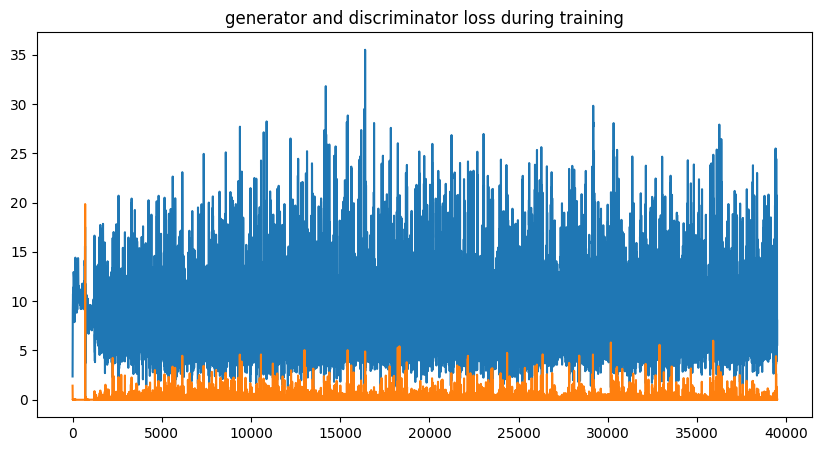

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title('generator and discriminator loss during training')
plt.plot(d,label='G')
plt.plot( e  ,label='D')
plt.show()

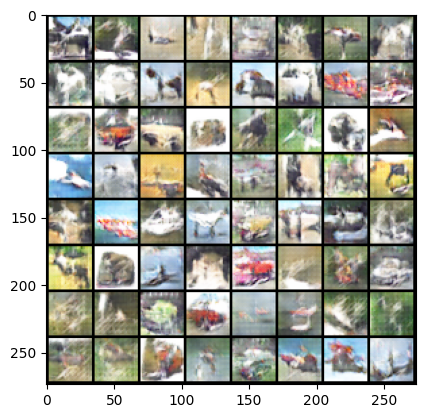

In [53]:
import numpy as np
ims = [[plt.imshow(np.transpose(i,(1,2,0)),animated=True)] for i in c]